In [1]:
import os

from torchvision.transforms import transforms
from torchvision.transforms.functional import center_crop, resize
from PIL import Image, ImageDraw

### Annotate Resized ExDark Images

In [2]:
original_annotations = []
for root, directory, files in os.walk("./datasets/ExDark_Annno/"):
    original_annotations += [os.path.join(root, file) for file in files]

In [3]:
target = "2015_00001"
image_path = os.path.join("./datasets/test/testA/", target + ".png")
img = Image.open(image_path)

In [4]:
resized_img = resize(img, size=286, interpolation=transforms.InterpolationMode.BICUBIC)
resized_ratio = (resized_img.size[0] / img.size[0], resized_img.size[1] / img.size[1])
cropped_img = center_crop(resized_img, 256)
cropped_margin = ((resized_img.size[0] - cropped_img.size[0]) / 2, (resized_img.size[1] - cropped_img.size[1]) / 2)

In [5]:
with open(list(filter(lambda x: target in x, original_annotations))[0]) as file:
    bboxes = [list(map(float, line.split()[1:5])) for line in file.readlines()[1:]]
    draw = ImageDraw.Draw(img)
    for l, t, w, h in bboxes:
        draw.rectangle([l, t, l + w, t + h])

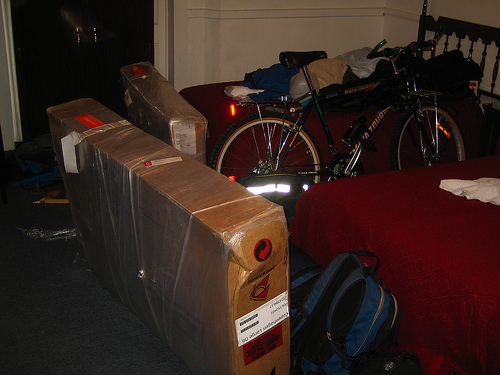

In [6]:
img

In [7]:
with open(list(filter(lambda x: target in x, original_annotations))[0]) as file:
    bboxes = [list(map(float, line.split()[1:5])) for line in file.readlines()[1:]]
    
    draw = ImageDraw.Draw(resized_img)
    for l, t, w, h in bboxes:
        top_lefts = (l * resized_ratio[0], t * resized_ratio[1])
        btn_right = ((l + w)  * resized_ratio[0], (t + h) * resized_ratio[1])
        draw.rectangle([top_lefts, btn_right])
    
    # draw.rectangle([0 + cropped_margin[0], 0 + cropped_margin[1], resized_img.size[0] - cropped_margin[0], resized_img.size[1] - cropped_margin[1]]) # Draw centered box

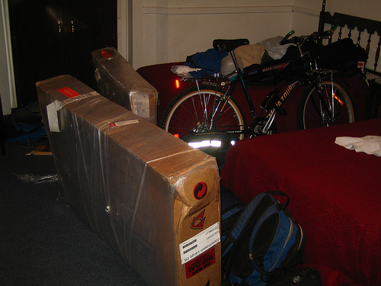

In [8]:
resized_img

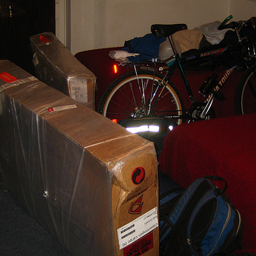

In [9]:
with open(list(filter(lambda x: target in x, original_annotations))[0]) as file:
    bboxes = [line.split()[0:1] + list(map(float, line.split()[1:5])) for line in file.readlines()[1:]]
    tmp = cropped_img.copy()
    size = tmp.size[0]
    draw = ImageDraw.Draw(tmp)
    for c, l, t, w, h in bboxes:
        x1, y1 = (l * resized_ratio[0]) - cropped_margin[0], (t * resized_ratio[1])  - cropped_margin[1]
        x2, y2 = ((l + w)  * resized_ratio[0])  - cropped_margin[0], ((t + h) * resized_ratio[1]) - cropped_margin[1]
        
        area = (x2 - x1) * (y2 - y1)
        
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(size, x2), min(size, y2)
        
        bounded_area = (x2 - x1) * (y2 - y1)
        
        if (bounded_area / area < 0.5): continue
        print(c)
                
        draw.rectangle([x1, y1, x2, y2])
tmp

In [10]:
destination = "./datasets/test/annotation/exp0/"

for root, _, files in os.walk("./datasets/test/testA/"):
    for file in files:
        img_path = os.path.join(root, file)
        fname = file.split('.')[0]

        img = Image.open(img_path)
        
        resized_img = resize(img, size=286, interpolation=transforms.InterpolationMode.BICUBIC)
        resized_ratio = (resized_img.size[0] / img.size[0], resized_img.size[1] / img.size[1])
        cropped_img = center_crop(resized_img, 256)
        cropped_margin = ((resized_img.size[0] - cropped_img.size[0]) / 2, (resized_img.size[1] - cropped_img.size[1]) / 2)
        
        with open(list(filter(lambda x: fname in x, original_annotations))[0]) as annotation:
            bboxes = [line.split()[0:1] + list(map(float, line.split()[1:5])) for line in annotation.readlines()[1:]]
            size = cropped_img.size[0]
            draw = ImageDraw.Draw(cropped_img)
            lines = []
            for c, l, t, w, h in bboxes:
                x1, y1 = (l * resized_ratio[0]) - cropped_margin[0], (t * resized_ratio[1])  - cropped_margin[1]
                x2, y2 = ((l + w)  * resized_ratio[0])  - cropped_margin[0], ((t + h) * resized_ratio[1]) - cropped_margin[1]
                
                area = (x2 - x1) * (y2 - y1)
                
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(size, x2), min(size, y2)
                
                bounded_area = (x2 - x1) * (y2 - y1)
                
                if (bounded_area / area < 0.5): continue
                
                lines.append([c, (x2 + x1) / 2, (y2 + y1) / 2, (x2 - x1), (y2 - y1)])
                
                draw.rectangle([x1, y1, x2, y2])
                
        with open(os.path.join(destination, 'labels', fname + '.txt'), 'w') as output:
            for line in lines:
                output.write("{} {:.6f} {:.6f} {:.6f} {:.6f}\n".format(*line))
        
        cropped_img.save(os.path.join(destination, file))       

In [12]:
destination = './datasets/test/annotation/exp0_6/'
labels = './datasets/test/annotation/exp6/labels/'
source = './datasets/test/result/real_X/'

for root, _, files in os.walk(source):
    for file in files:
        fname = file.split('.')[0]
        img = Image.open(os.path.join(root, file))
        draw = ImageDraw.Draw(img)
        
        try:
            with open(os.path.join(labels, fname + '.txt')) as annotation:
                size = img.size[0]
                
                bboxes = [line.split()[0:1] + list(map(lambda x: float(x) * size, line.split()[1:5])) for line in annotation.readlines()]
                            
                for c, x, y, w, h in bboxes:
                    x1 = x - (w / 2)
                    y1 = y - (h / 2)
                    x2 = x + (w / 2)
                    y2 = y + (w / 2)
                    
                    draw.rectangle([x1, y1, x2, y2])
        except:
            print("not found")
            
        img.save(os.path.join(destination, file))

not found
not found
not found
not found
not found
not found
